# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part E

## Implement Custom Resnet + Group conv path=4

In [3]:
class GroupedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GroupedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        shortcut = x

        # Paths
        paths = []
        for i in range(4):
            path = self.conv1(x)
            path = self.elu(path)
            path = self.conv2(path)
            paths.append(path)

        # Combine paths
        x = sum(paths)

        # Final combination with shortcut
        x += shortcut
        x = self.elu(x)

        return x

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = GroupedResidualBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.elu4 = nn.ELU()
        self.resblock2 = GroupedResidualBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): GroupedResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu3): ELU(alpha=1.0)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu4): ELU(alpha=1.0)
  (resblock2): GroupedResidualBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.2804, Train Accuracy: 15.96%, Val Loss: 2.2208, Val Accuracy: 22.48%
Epoch: 2, Train Loss: 2.1910, Train Accuracy: 25.52%, Val Loss: 2.1688, Val Accuracy: 28.06%
Epoch: 3, Train Loss: 2.1379, Train Accuracy: 31.40%, Val Loss: 2.1004, Val Accuracy: 35.56%
Epoch: 4, Train Loss: 2.0867, Train Accuracy: 36.88%, Val Loss: 2.0675, Val Accuracy: 38.96%
Epoch: 5, Train Loss: 2.0528, Train Accuracy: 40.38%, Val Loss: 2.0364, Val Accuracy: 42.02%
Epoch: 6, Train Loss: 2.0252, Train Accuracy: 43.10%, Val Loss: 2.0149, Val Accuracy: 44.42%
Epoch: 7, Train Loss: 2.0002, Train Accuracy: 45.62%, Val Loss: 1.9916, Val Accuracy: 46.72%
Epoch: 8, Train Loss: 1.9707, Train Accuracy: 48.74%, Val Loss: 1.9828, Val Accuracy: 47.38%
Epoch: 9, Train Loss: 1.9398, Train Accuracy: 52.05%, Val Loss: 1.9406, Val Accuracy: 51.70%
Epoch: 10, Train Loss: 1.9141, Train Accuracy: 54.63%, Val Loss: 1.9149, Val Accuracy: 54.44%
Epoch: 11, Train Loss: 1.8938, Train Accuracy: 56.61%, Val Loss: 1.89

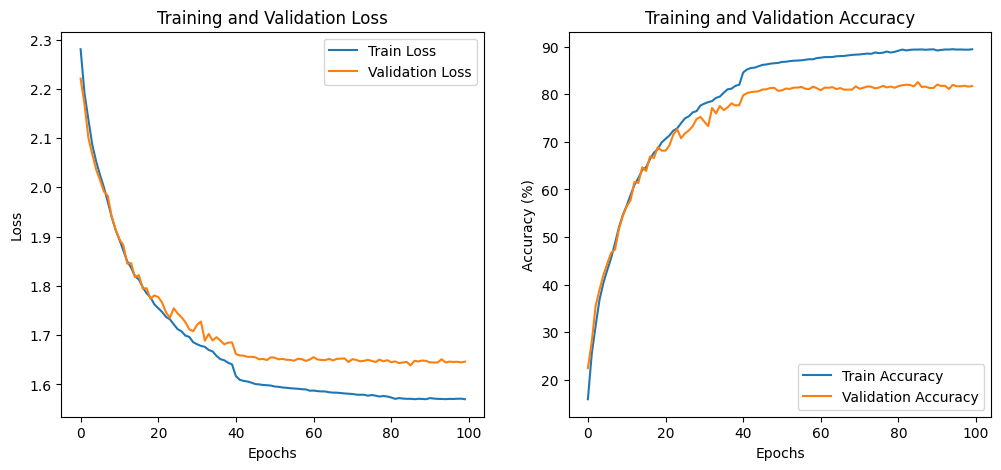

Best Validation Accuracy: 82.54%
Test Accuracy of the final model: 82.82%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_GP4.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1Rt9NDT6pjEqY_-wecU0WZFEfnxVxFxw2"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [4]:
class GroupedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GroupedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        shortcut = x

        # Paths
        paths = []
        for i in range(4):
            path = self.conv1(x)
            path = self.elu(path)
            path = self.conv2(path)
            paths.append(path)

        # Combine paths
        x = sum(paths)

        # Final combination with shortcut
        x += shortcut
        x = self.elu(x)

        return x

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = GroupedResidualBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.elu4 = nn.ELU()
        self.resblock2 = GroupedResidualBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [5]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate and load the model
model = CustomResNet()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_GP4.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): GroupedResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu3): ELU(alpha=1.0)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu4): ELU(alpha=1.0)
  (resblock2): GroupedResidualBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3

In [8]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {''}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 56.93it/s]


### Calc SI

In [10]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 351.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7423.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7452.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7358.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7977.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7623.24it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6976.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7848.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1747.04it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7922.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8469.92it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7848.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7035.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7460.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7080.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7104.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7322.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7169.75it/s]


In [11]:
si_layer_train

[('conv1', 0.22744444012641907),
 ('elu1', 0.2275555580854416),
 ('conv2', 0.20844444632530212),
 ('elu2', 0.21077777445316315),
 ('maxpool1', 0.31511110067367554),
 ('resblock1', 0.4067777693271637),
 ('maxpool2', 0.4803333282470703),
 ('conv3', 0.4587777853012085),
 ('elu3', 0.3955555558204651),
 ('maxpool3', 0.5794444680213928),
 ('conv4', 0.5680000185966492),
 ('elu4', 0.5270000100135803),
 ('resblock2', 0.7106666564941406),
 ('avgpool', 0.7831110954284668),
 ('flatten', 0.7831110954284668),
 ('fc1', 0.8184444308280945),
 ('fc2', 0.8230000138282776),
 ('softmax', 0.8653333187103271)]

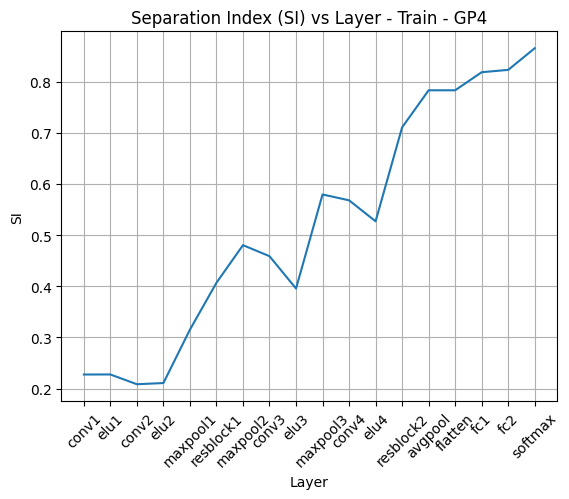

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Train - GP4')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [13]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 771.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4515.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4193.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4397.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3060.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3331.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4201.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4327.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4618.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4261.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3183.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3128.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4049.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2743.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2881.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3395.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4457.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4504.19it/s]


[('conv1', 0.3378888964653015), ('elu1', 0.3414444625377655), ('conv2', 0.34511110186576843), ('elu2', 0.3612222373485565), ('maxpool1', 0.4265555739402771), ('resblock1', 0.5131111145019531), ('maxpool2', 0.5687777996063232), ('conv3', 0.5296666622161865), ('elu3', 0.5561110973358154), ('maxpool3', 0.6330000162124634), ('conv4', 0.5638889074325562), ('elu4', 0.6221111416816711), ('resblock2', 0.7576666474342346), ('avgpool', 0.8144444823265076), ('flatten', 0.8144444823265076), ('fc1', 0.8686666488647461), ('fc2', 0.8551111221313477), ('softmax', 0.9011111259460449)]


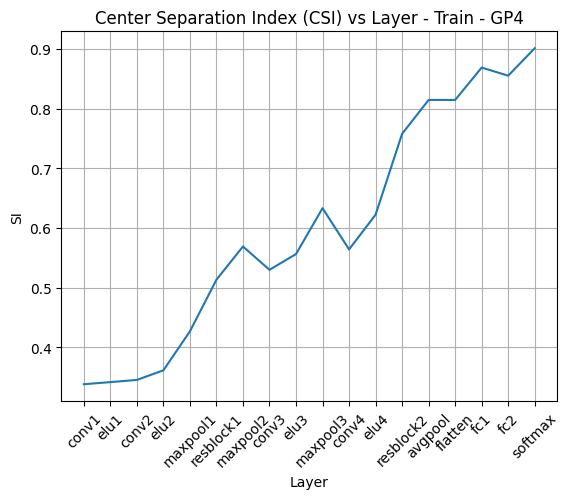

In [15]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train - GP4')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 21.09it/s]


### Calc SI

In [10]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 216.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5203.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5167.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5506.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4737.54it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5592.41it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4479.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5461.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5045.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4834.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4599.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5049.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5592.41it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5156.93it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5021.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5267.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4963.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4684.63it/s]


In [11]:
si_layer_val

[('conv1', 0.22379998862743378),
 ('elu1', 0.2255999892950058),
 ('conv2', 0.2141999900341034),
 ('elu2', 0.21480000019073486),
 ('maxpool1', 0.28540000319480896),
 ('resblock1', 0.37379997968673706),
 ('maxpool2', 0.43860000371932983),
 ('conv3', 0.41179999709129333),
 ('elu3', 0.37039998173713684),
 ('maxpool3', 0.536799967288971),
 ('conv4', 0.5349999666213989),
 ('elu4', 0.46779999136924744),
 ('resblock2', 0.6814000010490417),
 ('avgpool', 0.7784000039100647),
 ('flatten', 0.7784000039100647),
 ('fc1', 0.8227999806404114),
 ('fc2', 0.8330000042915344),
 ('softmax', 0.8341999650001526)]

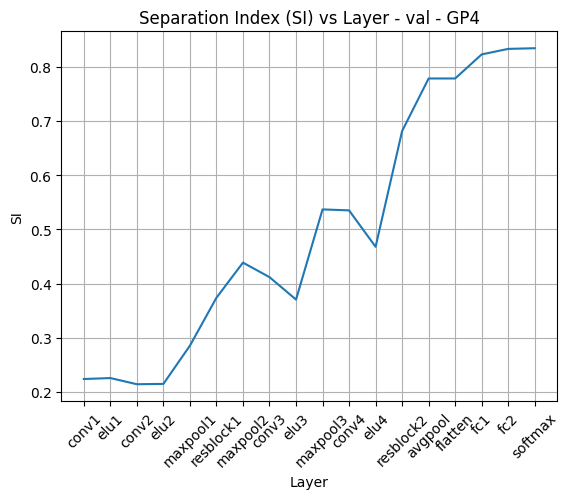

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - GP4')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [13]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 446.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3080.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3142.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3306.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3110.73it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2957.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2969.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3438.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3125.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2982.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3327.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3412.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3208.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1679.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2408.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2390.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3396.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3321.78it/s]


[('conv1', 0.3527999818325043), ('elu1', 0.3561999797821045), ('conv2', 0.3571999967098236), ('elu2', 0.37279999256134033), ('maxpool1', 0.4343999922275543), ('resblock1', 0.5171999931335449), ('maxpool2', 0.5719999670982361), ('conv3', 0.527999997138977), ('elu3', 0.5550000071525574), ('maxpool3', 0.6453999876976013), ('conv4', 0.5719999670982361), ('elu4', 0.6308000087738037), ('resblock2', 0.7595999836921692), ('avgpool', 0.8245999813079834), ('flatten', 0.8245999813079834), ('fc1', 0.8761999607086182), ('fc2', 0.8621999621391296), ('softmax', 0.9079999923706055)]


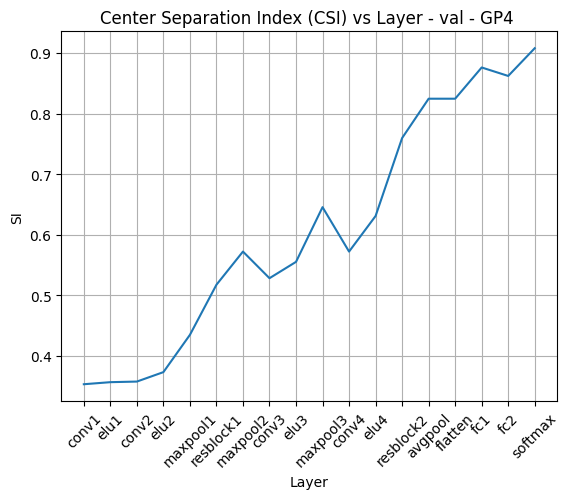

In [15]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - GP4 ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 25.40it/s]


### Calc SI

In [10]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 359.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7106.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7626.01it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7645.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7096.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7562.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7296.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1864.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7872.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7799.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7687.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7522.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6869.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7415.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7727.16it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7958.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7538.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7152.63it/s]


In [11]:
si_layer_test

[('conv1', 0.22789999842643738),
 ('elu1', 0.22819998860359192),
 ('conv2', 0.21249999105930328),
 ('elu2', 0.2142999917268753),
 ('maxpool1', 0.3042999804019928),
 ('resblock1', 0.41279998421669006),
 ('maxpool2', 0.48330000042915344),
 ('conv3', 0.45719999074935913),
 ('elu3', 0.41029998660087585),
 ('maxpool3', 0.578000009059906),
 ('conv4', 0.5737000107765198),
 ('elu4', 0.5199999809265137),
 ('resblock2', 0.6829000115394592),
 ('avgpool', 0.7231999635696411),
 ('flatten', 0.7231999635696411),
 ('fc1', 0.7368999719619751),
 ('fc2', 0.733299970626831),
 ('softmax', 0.7754999995231628)]

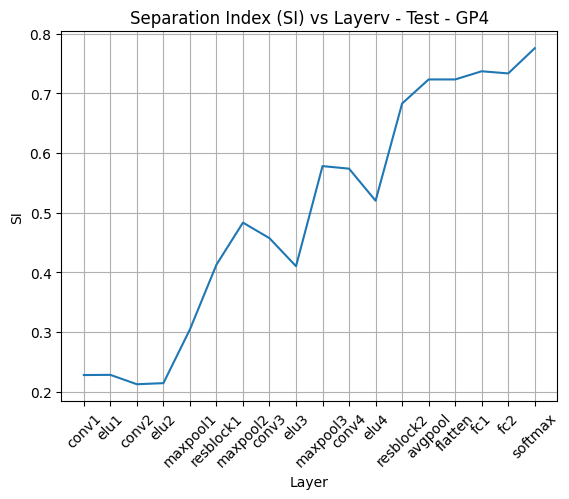

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layerv - Test - GP4')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [13]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 725.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4639.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4228.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4665.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3105.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3177.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4149.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4294.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4643.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4156.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3256.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3231.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4375.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4052.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4241.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4322.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4132.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4369.07it/s]


[('conv1', 0.3464999794960022), ('elu1', 0.35029998421669006), ('conv2', 0.349700003862381), ('elu2', 0.36409997940063477), ('maxpool1', 0.4296000003814697), ('resblock1', 0.5116999745368958), ('maxpool2', 0.569599986076355), ('conv3', 0.5289999842643738), ('elu3', 0.5530999898910522), ('maxpool3', 0.6275999546051025), ('conv4', 0.5641999840736389), ('elu4', 0.6186999678611755), ('resblock2', 0.7264999747276306), ('avgpool', 0.7675999999046326), ('flatten', 0.7675999999046326), ('fc1', 0.8032000064849854), ('fc2', 0.7884999513626099), ('softmax', 0.8280999660491943)]


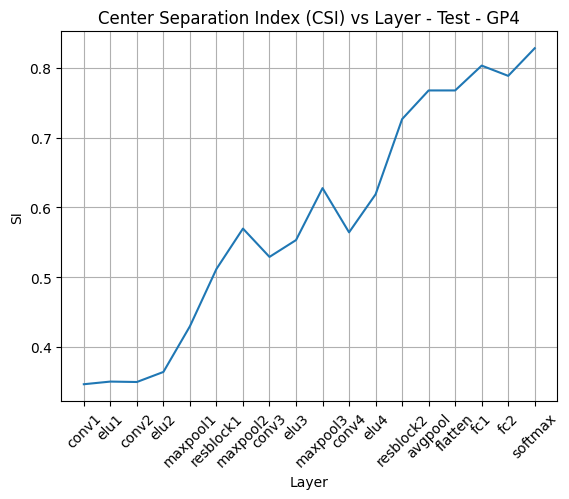

In [14]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - GP4')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()